In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack

In [2]:
exp_id = 5

# model_name = 'train_mnist_exp%d.h5' % exp_id
# net = BasicModel()

model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

In [3]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [4]:
y_pred = net(x_test.to(device))

In [5]:
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9903

In [6]:
# x_train = x_train.to(device)
# x_test = x_test.to(device)
# x_valid = x_valid.to(device)

In [7]:
net

SNNLModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [8]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
layers = ['relu1', 'relu2', 'relu3']
# layers = ['relu3']
# net = net.cpu()
with torch.no_grad():
    dknn = DKNN(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [9]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.9639

In [10]:
cred = dknn.credibility(y_pred)

(array([ 989.,  871., 1227., 1022.,  529., 1101., 1291.,  818.,    0.,
        2152.]),
 array([0.016 , 0.1144, 0.2128, 0.3112, 0.4096, 0.508 , 0.6064, 0.7048,
        0.8032, 0.9016, 1.    ]),
 <a list of 10 Patch objects>)

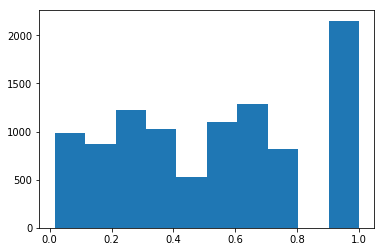

In [11]:
plt.hist(cred)

In [12]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

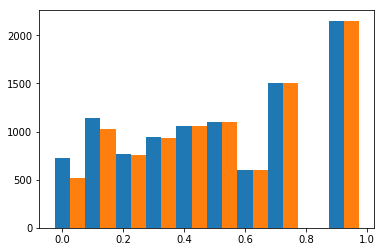

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [14]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.7140884 , 0.90316901, 0.9753886 , 0.99045599, 0.99529633,
       1.        , 0.99169435, 0.99734572,        nan, 0.99907063])

In [15]:
dknn.A.mean()

6.2455

## PGD Attack

In [12]:
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.numpy()

In [13]:
model = foolbox.models.PyTorchModel(net, bounds=(0, 1), num_classes=10)

In [6]:
criterion = foolbox.criteria.Misclassification()
distance = foolbox.distances.Linfinity

attack = foolbox.attacks.RandomPGD(
    model, criterion=criterion, distance=distance)

def attack_wrap(x, y):
    return attack(x, y, binary_search=False, epsilon=0.3, 
                  stepsize=0.01, iterations=40, 
                  random_start=True, return_early=True)

x_adv = np.zeros_like(x_test)
for i, (x, y) in enumerate(zip(x_test, y_test)):
    x_adv[i] = attack_wrap(x, y)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [ ]:
with torch.no_grad():
    x_adv = torch.tensor(x_adv).to(device)
    y_pred = net(x_adv).detach().cpu().numpy()
np.mean(np.argmax(y_pred, 1) == y_test)

In [ ]:
from lib.pgd_attack import PGDAttack

attack = PGDAttack()
x_adv = attack(net, x_test, y_test.to(device),
               targeted=False, epsilon=0.1, max_epsilon=0.3,
               max_iterations=20, random_restart=10)

In [23]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test).sum()

tensor(0)

In [54]:
y_pred = dknn.classify(x_adv.cpu())
(y_pred.argmax(1) == y_test.numpy()).sum()

813

(array([9.63e+03, 2.96e+02, 5.70e+01, 7.00e+00, 5.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 4.00e+00]),
 array([0.00383333, 0.10345   , 0.20306667, 0.30268333, 0.4023    ,
        0.50191667, 0.60153333, 0.70115   , 0.80076667, 0.90038333,
        1.        ]),
 <a list of 10 Patch objects>)

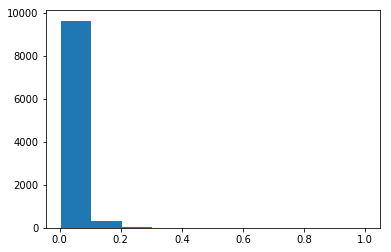

In [55]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [11]:
np.mean(y_pred == y_test)

0.9091

## DkNN Attack

In [16]:
attack = DKNNAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y_test[begin:end],
            guide_layer='relu1', m=100, binary_search_steps=5,
            max_iterations=500, learning_rate=1e-1,
            initial_const=1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000], 100)

    step: 0; loss: -80.440; l2dist: 0.000
    step: 50; loss: -82.018; l2dist: 1.087
    step: 100; loss: -82.317; l2dist: 1.147
    step: 150; loss: -83.122; l2dist: 1.267
    step: 200; loss: -83.302; l2dist: 1.287
    step: 250; loss: -83.353; l2dist: 1.294
    step: 300; loss: -83.372; l2dist: 1.296
    step: 350; loss: -83.380; l2dist: 1.296
    step: 400; loss: -83.384; l2dist: 1.297
    step: 450; loss: -83.386; l2dist: 1.298
binary step: 0; number of successful adv: 25/100
    step: 0; loss: -614.022; l2dist: 0.000
    step: 50; loss: -650.750; l2dist: 2.766
    step: 100; loss: -661.638; l2dist: 2.715
    step: 150; loss: -662.557; l2dist: 2.734
    step: 200; loss: -662.753; l2dist: 2.751
    step: 250; loss: -662.823; l2dist: 2.755
    step: 300; loss: -662.851; l2dist: 2.757
    step: 350; loss: -662.864; l2dist: 2.759
    step: 400; loss: -662.871; l2dist: 2.759
    step: 450; loss: -662.878; l2dist: 2.760
binary step: 1; number of successful adv: 81/100
    step: 0; loss:

    step: 200; loss: -578.971; l2dist: 2.492
    step: 250; loss: -579.043; l2dist: 2.499
    step: 300; loss: -579.077; l2dist: 2.502
    step: 350; loss: -579.096; l2dist: 2.503
    step: 400; loss: -579.105; l2dist: 2.504
    step: 450; loss: -579.109; l2dist: 2.504
binary step: 1; number of successful adv: 84/100
    step: 0; loss: -1544.209; l2dist: 0.000
    step: 50; loss: -1624.218; l2dist: 2.257
    step: 100; loss: -1651.361; l2dist: 2.326
    step: 150; loss: -1654.088; l2dist: 2.365
    step: 200; loss: -1654.948; l2dist: 2.384
    step: 250; loss: -1655.420; l2dist: 2.401
    step: 300; loss: -1655.648; l2dist: 2.408
    step: 350; loss: -1655.722; l2dist: 2.411
    step: 400; loss: -1655.856; l2dist: 2.415
    step: 450; loss: -1655.941; l2dist: 2.413
binary step: 2; number of successful adv: 87/100
    step: 0; loss: -11018.104; l2dist: 0.000
    step: 50; loss: -11605.492; l2dist: 1.977
    step: 100; loss: -11751.955; l2dist: 2.092
    step: 150; loss: -11770.266; l2di

    step: 400; loss: -1376.543; l2dist: 2.643
    step: 450; loss: -1376.579; l2dist: 2.644
binary step: 2; number of successful adv: 94/100
    step: 0; loss: -5386.077; l2dist: 0.000
    step: 50; loss: -5711.422; l2dist: 2.216
    step: 100; loss: -5778.987; l2dist: 2.255
    step: 150; loss: -5788.471; l2dist: 2.284
    step: 200; loss: -5790.907; l2dist: 2.303
    step: 250; loss: -5792.930; l2dist: 2.311
    step: 300; loss: -5793.813; l2dist: 2.314
    step: 350; loss: -5794.226; l2dist: 2.316
    step: 400; loss: -5794.733; l2dist: 2.318
    step: 450; loss: -5794.891; l2dist: 2.319
binary step: 3; number of successful adv: 96/100
    step: 0; loss: -34147.898; l2dist: 0.000
    step: 50; loss: -36139.121; l2dist: 1.956
    step: 100; loss: -36561.980; l2dist: 2.014
    step: 150; loss: -36637.934; l2dist: 2.053
    step: 200; loss: -36654.508; l2dist: 2.066
    step: 250; loss: -36661.016; l2dist: 2.076
    step: 300; loss: -36665.461; l2dist: 2.081
    step: 350; loss: -36668

    step: 50; loss: -61642.387; l2dist: 1.890
    step: 100; loss: -62589.910; l2dist: 2.002
    step: 150; loss: -62682.020; l2dist: 2.048
    step: 200; loss: -62714.137; l2dist: 2.070
    step: 250; loss: -62731.023; l2dist: 2.079
    step: 300; loss: -62739.785; l2dist: 2.085
    step: 350; loss: -62754.770; l2dist: 2.086
    step: 400; loss: -62767.652; l2dist: 2.089
    step: 450; loss: -62769.719; l2dist: 2.090
binary step: 4; number of successful adv: 95/100


In [17]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.052

(array([589., 232.,  81.,  21.,  10.,   6.,   9.,   2.,   0.,  50.]),
 array([0.016 , 0.1144, 0.2128, 0.3112, 0.4096, 0.508 , 0.6064, 0.7048,
        0.8032, 0.9016, 1.    ]),
 <a list of 10 Patch objects>)

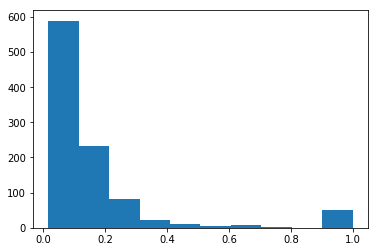

In [18]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

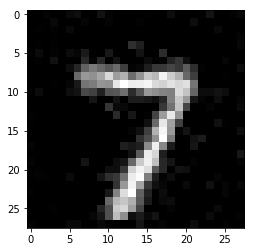

In [19]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [20]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(1.9802, grad_fn=<MeanBackward1>)

## CW L2 Attack

without DkNN

In [83]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000].cuda(), 100)

    step: 0; loss: 6.370; l2dist: 0.000
    step: 50; loss: 2.131; l2dist: 1.295
    step: 100; loss: 1.019; l2dist: 0.932
    step: 150; loss: 0.705; l2dist: 0.782
    step: 200; loss: 0.616; l2dist: 0.734
    step: 250; loss: 0.576; l2dist: 0.715
    step: 300; loss: 0.561; l2dist: 0.705
    step: 350; loss: 0.551; l2dist: 0.697
    step: 400; loss: 0.547; l2dist: 0.691
    step: 450; loss: 0.541; l2dist: 0.688
binary step: 0; number of successful adv: 86/100
    step: 0; loss: 11.855; l2dist: 0.000
    step: 50; loss: 2.109; l2dist: 1.210
    step: 100; loss: 1.033; l2dist: 0.904
    step: 150; loss: 0.709; l2dist: 0.765
    step: 200; loss: 0.633; l2dist: 0.727
    step: 250; loss: 0.601; l2dist: 0.715
    step: 300; loss: 0.558; l2dist: 0.691
    step: 350; loss: 0.549; l2dist: 0.683
    step: 400; loss: 0.559; l2dist: 0.693
binary step: 1; number of successful adv: 98/100
    step: 0; loss: 20.056; l2dist: 0.000
    step: 50; loss: 2.174; l2dist: 1.194
    step: 100; loss: 1.123;

    step: 50; loss: 2.032; l2dist: 1.121
    step: 100; loss: 1.156; l2dist: 0.939
    step: 150; loss: 0.756; l2dist: 0.789
    step: 200; loss: 0.656; l2dist: 0.743
    step: 250; loss: 0.611; l2dist: 0.719
    step: 300; loss: 0.596; l2dist: 0.709
    step: 350; loss: 0.583; l2dist: 0.701
    step: 400; loss: 0.574; l2dist: 0.696
    step: 450; loss: 0.567; l2dist: 0.694
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 6.031; l2dist: 0.000
    step: 50; loss: 1.950; l2dist: 1.077
    step: 100; loss: 1.165; l2dist: 0.938
    step: 150; loss: 0.756; l2dist: 0.784
    step: 200; loss: 0.654; l2dist: 0.744
    step: 250; loss: 0.610; l2dist: 0.716
    step: 300; loss: 0.594; l2dist: 0.699
    step: 350; loss: 0.580; l2dist: 0.697
    step: 400; loss: 0.578; l2dist: 0.695
    step: 450; loss: 0.566; l2dist: 0.694
binary step: 4; number of successful adv: 100/100
    step: 0; loss: 5.975; l2dist: 0.000
    step: 50; loss: 1.968; l2dist: 1.209
    step: 100; loss: 1.07

    step: 50; loss: 2.602; l2dist: 1.414
    step: 100; loss: 1.187; l2dist: 1.011
    step: 150; loss: 0.808; l2dist: 0.837
    step: 200; loss: 0.703; l2dist: 0.784
    step: 250; loss: 0.666; l2dist: 0.764
    step: 300; loss: 0.643; l2dist: 0.744
    step: 350; loss: 0.648; l2dist: 0.753
binary step: 1; number of successful adv: 99/100
    step: 0; loss: 16.946; l2dist: 0.000
    step: 50; loss: 2.396; l2dist: 1.313
    step: 100; loss: 1.150; l2dist: 0.961
    step: 150; loss: 0.796; l2dist: 0.816
    step: 200; loss: 0.687; l2dist: 0.760
    step: 250; loss: 0.644; l2dist: 0.739
    step: 300; loss: 0.633; l2dist: 0.734
    step: 350; loss: 0.626; l2dist: 0.731
    step: 400; loss: 0.632; l2dist: 0.729
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 10.464; l2dist: 0.000
    step: 50; loss: 2.161; l2dist: 1.198
    step: 100; loss: 1.114; l2dist: 0.920
    step: 150; loss: 0.773; l2dist: 0.796
    step: 200; loss: 0.682; l2dist: 0.758
    step: 250; loss: 0.6

In [94]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test[:1000]).numpy().sum() / y_pred.size(0)

0.0

In [95]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.756

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

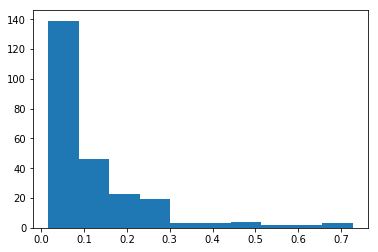

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:1000].numpy()
plt.hist(cred[suc_ind])

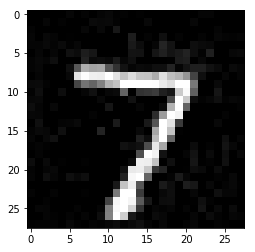

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [88]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(0.7349, grad_fn=<MeanBackward1>)

---

In [27]:
# Set all random seeds
exp_id = 0
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'train_mnist_cav_exp%d.h5' % exp_id
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [32]:
x_train = x_train.to(device)
x_test = x_test.to(device)
x_valid = x_valid.to(device)

In [28]:
net

ClassAuxVAE(
  (en_conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (en_conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (en_conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (en_fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU(inplace)
  (en_mu): Linear(in_features=128, out_features=20, bias=True)
  (en_logvar): Linear(in_features=128, out_features=20, bias=True)
  (de_fc1): Linear(in_features=20, out_features=128, bias=True)
  (de_fc2): Linear(in_features=128, out_features=1568, bias=True)
  (ax_fc1): Linear(in_features=20, out_features=128, bias=True)
  (ax_fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [59]:
layers = ['en_mu']
net = net.to(device)
with torch.no_grad():
    dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [60]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.964

(array([ 741., 1243.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8016.]),
 array([0.01683333, 0.11515   , 0.21346667, 0.31178333, 0.4101    ,
        0.50841667, 0.60673333, 0.70505   , 0.80336667, 0.90168333,
        1.        ]),
 <a list of 10 Patch objects>)

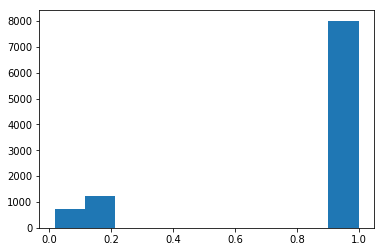

In [61]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [62]:
from lib.dknn_attack import DKNNAttack

attack = DKNNAttack()
x_adv = attack(dknn, x_test[:1000], y_test[:1000],
               guide_layer='en_mu', binary_search_steps=5,
               max_iterations=500, learning_rate=1e-1,
               initial_const=1, abort_early=True)

    step: 0; loss: -10.374; l2dist: 0.000
    step: 50; loss: -16.516; l2dist: 2.206
    step: 100; loss: -17.532; l2dist: 2.233
    step: 150; loss: -21.379; l2dist: 2.383
    step: 200; loss: -23.950; l2dist: 2.461
    step: 250; loss: -25.525; l2dist: 2.522
    step: 300; loss: -26.562; l2dist: 2.575
    step: 350; loss: -27.237; l2dist: 2.610
    step: 400; loss: -27.690; l2dist: 2.641
    step: 450; loss: -27.980; l2dist: 2.662
binary step: 0; number of successful adv: 732/1000
    step: 0; loss: -31.082; l2dist: 0.000
    step: 50; loss: -80.035; l2dist: 2.555
    step: 100; loss: -102.080; l2dist: 2.891
    step: 150; loss: -113.852; l2dist: 3.048
    step: 200; loss: -119.545; l2dist: 3.074
    step: 250; loss: -122.952; l2dist: 3.069
    step: 300; loss: -125.118; l2dist: 3.057
    step: 350; loss: -126.465; l2dist: 3.052
    step: 400; loss: -127.398; l2dist: 3.048
    step: 450; loss: -127.963; l2dist: 3.048
binary step: 1; number of successful adv: 1000/1000
    step: 0; lo

In [18]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum()

0

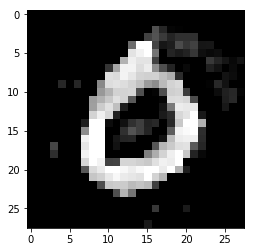

In [56]:
plt.imshow(x_adv[3].cpu().detach().numpy().squeeze(), cmap='gray')

In [20]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(1.9813, grad_fn=<MeanBackward1>)